## Exam number: Y3863437

# Question 1

Start by importing the modules that will be needed and importing the dataset used for Q1 and Q2 (data.csv which for convenience purpose is renamed to data_q1q2.csv). Split the data into test and training sets.

When choosing the size of the training data set, multiple iterations were made until a size that gave the most optimal R2 and mean squared error was found. Underfitting issues were observed, when the training data size was dropped lower than 80, however going for a training size set that was bigger than 130 the R2 score started to drop significantly, while the squared error rose up. This means, that since a time-lagged variable is being predicted, if the training set size is bigger than 130 then the model is being overfitted, as it tends to predict the D value of current row/time.

In [51]:
import numpy

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import RidgeCV, LinearRegression, LassoCV, LassoLarsCV
from sklearn.preprocessing import PolynomialFeatures
from scipy import optimize

data = numpy.loadtxt('data_q1.csv', delimiter=',', skiprows=1)  # Load renamed data.csv

# Make size variables for data, training data and test data. Training size can be controlled.
data_size = len(data)  # 228 from the given file
training_size = 120  # 120 is the best value- trial and error
test_size = data_size - training_size

print(f'DATA: {data_size}; TRAINING: {training_size}; TEST: {test_size}')

# Split into training and test sizes
data_train = data[:training_size]
data_test = data[-test_size:]

DATA: 228; TRAINING: 120; TEST: 108


Now, start off by breaking up the test data set. Since we are predicting value for variable D with a time-lag, both test and train data Y sets will be shifted by one value.

In [52]:
data_test_x = data_test[:-1]  # Omit the last row, since we do not care about D value at the current time

data_test_y = data_test[:,-1]
data_test_y = numpy.delete(data_test_y, 0)  # Delete the last value, since it's not used for time-lagged value

### Basic linear regression

In [53]:
data_train_x = data_train  # Since we are using all 4 variables for prediction

data_train_y = data[:,-1]
data_train_y = numpy.delete(data_train_y, 0)[:training_size]  # Same as for test data set

# Linear regression
linearRegression = LinearRegression()
linearRegression.fit(data_train_x, data_train_y)

data_predict_y = linearRegression.predict(data_test_x)

print(f'The R2 score of basic linear regression model is: {r2_score(data_test_y, data_predict_y)}')
print(f'Mean squared error: {mean_squared_error(data_test_y, data_predict_y)}')

The R2 score of basic linear regression model is: 0.9211494084552628
Mean squared error: 0.07688597282309757


To visualize the predicted values, the test values are scattered, while the predicted values are plotted with a blue line.

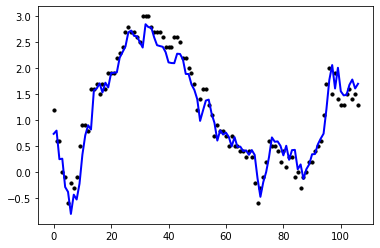

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter([i for i in range(test_size-1)], data_test_y,  color='black', s=10)
plt.plot([i for i in range(test_size-1)], data_predict_y, color='blue', linewidth=2)
plt.show()

The R2 score for basic linear regression model seems to be quite close enough to 1. However, when looking at predicted values and the desired values, it can be clearly seen, that this current model is predicting values, that are more closer to the current-time/row value instead of time-lagged one.

When looking at the data values themselves when they are plotted, it can be seen that a linear line is not the best option. However, it can be further tweaked, to try and get better prediction results.

### Ridge and Lasso regression

In [55]:
alphas_to_try = numpy.logspace(-10, 10, 200)

ridgeReg = RidgeCV(alphas=alphas_to_try)
ridgeReg.fit(data_train_x, data_train_y)
data_predict_y_ridge = ridgeReg.predict(data_test_x)

print(f'Chosen alpha for Ridge: {ridgeReg.alpha_}')
print(f'R2 score of ridge regression: {r2_score(data_test_y, data_predict_y_ridge)}')
print(f'Mean squared error: {mean_squared_error(data_test_y, data_predict_y_ridge)}')

lassoReg = LassoCV(alphas=alphas_to_try)
lassoReg.fit(data_train_x, data_train_y)
data_predict_y_lasso = lassoReg.predict(data_test_x)

print('\n')
print(f'Chosen alpha for Lasso: {lassoReg.alpha_}')
print(f'R2 score of lasso regression: {r2_score(data_test_y, data_predict_y_lasso)}')
print(f'Mean squared error: {mean_squared_error(data_test_y, data_predict_y_lasso)}')

Chosen alpha for Ridge: 1e-10
R2 score of ridge regression: 0.9211173059308322
Mean squared error: 0.07691727549023776


Chosen alpha for Lasso: 0.0034489622604057598
R2 score of lasso regression: 0.926101783879955
Mean squared error: 0.07205698936396118


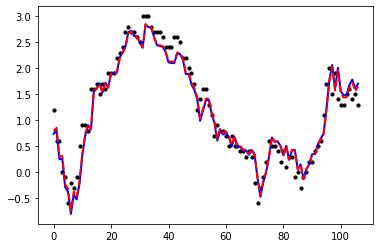

In [101]:
plt.scatter([i for i in range(test_size-1)], data_test_y,  color='black', s=10)
plt.plot([i for i in range(test_size-1)], data_predict_y_ridge, color='blue', linewidth=2)
plt.plot([i for i in range(test_size-1)], data_predict_y_lasso, color='red', linestyle='dashed', linewidth=2)
plt.show()

For Ridge and Lasso regressions, here the bias is increased, while variance is being decreased. While no significant results can be observed in contrast with regular linear regression, lasso regression model does increase the R2 score by a bit, while also decreasing the mean squared error.

While also looking at the alpha values, it can be seen, that ridge regression, because of its nature to asymptotically shrink the slope to 0 and not all the way, the alpha chosen is the lowest possible from the set of all possible alpha values provided. However, for lasso model, it can be seen that the alpha value chosen is not either the min or max value, that way the line has been fitted more reasonably to the data provided (time-lagged variable D). This, as mentioned previously, can be seen with the increase of R2 and decrease of mean squared error.

### Polynomial regression

To try and increase the R2 score of the linear regression model, a polynomial regression together with a LassoLars. From the scikit-learn documentation, LassoLars is explained to be a lasso model implemented together with LARS algorithm, which yelds a solution with piecewise linear properties.

Before LassoLars model was chosen, the polynomial model was tried with LinearRegression, Ridge and Lasso models. None of the previously mentioned got close to the desired results. This can be explained (as later on seen), that the time-lagged 'D' variable does not have a quadrattic or any higher power polynomial tendency.

Variable 'degree_chosen' is the polynomial degree to be set.

Biggest R2 value seen: 0.7996951124818169
Alpha value at the R2 value: 0.11473514853543713
Mean squared error: 0.19531414839568884


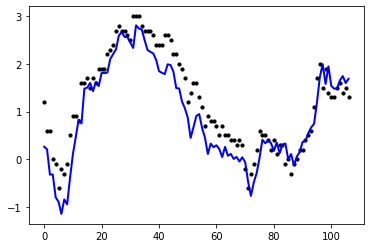

In [102]:
# Set the degree
degree_chosen = 2

# Setup for polynomial feature
poly = PolynomialFeatures(degree=degree_chosen)
data_train_x_poly = poly.fit_transform(data_train_x)

# LassoLars model, fit the data
lassoLars = LassoLarsCV(cv=8, normalize=False)
lassoLars.fit(data_train_x_poly, data_train_y)

# Get the desired attributes
data_predict_y = lassoLars.predict(poly.fit_transform(data_test_x))
final_r2 = r2_score(data_test_y, data_predict_y)
final_error = mean_squared_error(data_test_y, data_predict_y)
        
print(f'Biggest R2 value seen: {final_r2}')
print(f'Alpha value at the R2 value: {lassoLars.alpha_}')
print(f'Mean squared error: {final_error}')

# Plot the predicted values against the true values
plt.scatter([i for i in range(test_size-1)], data_test_y,  color='black', s=10)
plt.plot([i for i in range(test_size-1)], data_predict_y, color='blue', linewidth=2)

plt.show()

As the degree for polynomial feature increases, the best R2 score found tends to get lower. For this reason, the best degree that can be chosen is of value 2. Obvisously, if the value is 1, then it is a plain linear regression. 

As it can be seen from the final results, the R2 value is still worse than when applying just a linear regression model on its own. This suggests, that polynomial regression is not the way forwards. These results especially were taken in account, when building the final model for this set of data.

### Final model

When taking in account everything that has been done so far, the final model can be made. For the final model, LassoLars model is used, as it was proven in previous section that it gives the best result. The code below is similar to the one above, however as it proven before, the polynomial regression is not needed, therefore, after excluding it (in other words, degree=1) the best result yet is achieved.

Altough the R2 score has not increased by much, it can be seen that it still is higher than when LinearRegression model or Ridge/Lasso model was used on its own. It can also be observed, that the mean squared error has decreased.

This can be explained by the simple nature of LassoLars model- since the model used is a piecewise regression

Alpha value: 0.011070957707378816
R2 score: 0.9290765798496755
Mean squared error: 0.06915631255733978


R2 score for only 20 of the test data: 0.8266860021893225
Mean squared error for only 20 of the test data: 0.07093308645396504


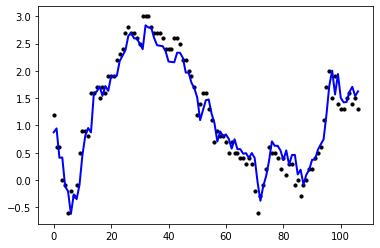

In [103]:
LassoLarsModel = LassoLarsCV(normalize=False, cv=9)
LassoLarsModel.fit(data_train_x, data_train_y)
data_predict_y_lars = LassoLarsModel.predict(data_test_x)

print(f'Alpha value: {LassoLarsModel.alpha_}')
print(f'R2 score: {r2_score(data_test_y, data_predict_y_lars)}')
print(f'Mean squared error: {mean_squared_error(data_test_y, data_predict_y_lars)}')

print('\n')
print(f'R2 score for only 20 of the test data: {r2_score(data_test_y[-20:], data_predict_y_lars[-20:])}')
print(f'Mean squared error for only 20 of the test data: {mean_squared_error(data_test_y[-20:], data_predict_y_lars[-20:])}')

# Plot the predicted values against the true values
plt.scatter([i for i in range(test_size-1)], data_test_y,  color='black', s=10)
plt.plot([i for i in range(test_size-1)], data_predict_y_lars, color='blue', linewidth=2)

plt.show()

The fact, that if we test a bigger data set on the model and the R2 score grows overall, cant be ignored. As it can be seen, if tested on a smaller batch size, then R2 score starts to significantly drop. However, even when the training data set size is changed, it has been concluded (trial-error) that for both bigger test size and smaller test-size batches, the R2 score remains to be the best when only half of the available data set is trained for the model. 

With this model, cross validation is also used, as it is easier to estimate the alpha value from the cross-validation errors. When choosing how many folds are needed, the K number was changed multiple times, however in this case the number of folds did not affect the final result as previously thought, however it did seem like that the anything higher than 10 was giving slightly worse results, while 9 seemed to maximise the R2 score for this particular test dataset.

### Testing unseendata.csv by using the final model

In [25]:
unseendata = numpy.loadtxt('unseendata.csv', delimiter=',', skiprows=1)  # Load in the test dataset

unseendata_test_x = unseendata[:-1]  # Omit the last row, since we do not care about D value at the current time

unseendata_test_y = unseendata[:,-1]
unseendata_test_y = numpy.delete(unseendata_test_y, 0)  # Delete the last value, since it's not used for time-lagged value

unseendata_predict_y = LassoLarsModel.predict(unseendata_test_x)  # Predict the D time-lagged values by using the final model trained

print(f'R2 score for test dataset: {r2_score(unseendata_test_y, unseendata_predict_y)}')
print(f'Mean squared error for test dataset: {mean_squared_error(unseendata_test_y, unseendata_predict_y)}')

R2 score for test dataset: 0.9321064942939286
Mean squared error for test dataset: 0.06058276294702654


<hr></hr>

# Question 2

For question 2, the data.csv file has been modified according to the instructions and has been renamed to data_q2.csv for convenience. Start by importing needed packages and setting up the data.

In [89]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

data = numpy.loadtxt('data_q2.csv', delimiter=',', skiprows=1)  # As always, load in the data

Now, the variance of the original data can be seen. Since the data will be scaled for PCA, before getting the variance of original variables, the data is scaled before hand (since the total variance is the same for both the original and PCA).

In [114]:
sum_of_original_variances = 0

data = preprocessing.scale(data)

for i, d in enumerate(data):
    if i < 12:
        variance = numpy.var(data[:,i])
        print(f'Variance of variable {i}: {variance}')
        sum_of_original_variances += variance
        
print(f'\n Sum of original variances: {sum_of_original_variances}')

Variance of variable 0: 1.0000000000000002
Variance of variable 1: 1.0000000000000002
Variance of variable 2: 1.0
Variance of variable 3: 0.9999999999999993
Variance of variable 4: 1.0000000000000002
Variance of variable 5: 0.9999999999999993
Variance of variable 6: 1.0000000000000033
Variance of variable 7: 0.9999999999999984
Variance of variable 8: 1.0
Variance of variable 9: 0.9999999999999988
Variance of variable 10: 1.000000000000002
Variance of variable 11: 1.0000000000000002

 Sum of original variances: 12.000000000000002


From the results above, it seems that each variable accounts for an equal fraction of the total variance.

From here on now, PCA can be applied with 12 prinicipal components (number of variables). After that, the data is fitted and transformed. The PC variance percentage is drawn on a bar graph for a better understanding of which PC is more important.

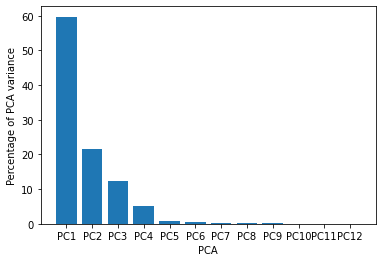

Sum of all PCs variances: 12.053333333333327

Percentage of PC1: 59.7%
Percentage of PC2: 21.5%
Percentage of PC3: 12.4%
Percentage of PC4: 5.0%
Percentage of PC5: 0.7%
Percentage of PC6: 0.4%
Percentage of PC7: 0.2%
Percentage of PC8: 0.1%
Percentage of PC9: 0.1%
Percentage of PC10: 0.0%
Percentage of PC11: 0.0%
Percentage of PC12: 0.0%


In [130]:
pca = PCA(n_components=12)
pca.fit(data)
pca_data = pca.fit_transform(data)

pca_variance_percentage = numpy.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(pca_variance_percentage)+1)]

plt.bar(x=range(1,len(pca_variance_percentage)+1), height=pca_variance_percentage, tick_label=labels)
plt.ylabel('Percentage of PCA variance')
plt.xlabel('PCA')
plt.show()

sum_of_PCA_variances = sum(pca.explained_variance_) 
print(f'Sum of all PCs variances: {sum_of_PCA_variances}\n')
for i, var in enumerate(pca_variance_percentage):
    print(f'Percentage of PC{i+1}: {var}%')

The sum of all PC variance is the same as the original (altough, it can be seen that its not the same, but close- this can be explained with the limitations of floating point). Moreover, it is clear that the first variable (A / PC1) accounts for almost 60% of the total variance. This suggests, that the first variable has the biggest impact of the data. Furthermore, it can be seen that together PC1, PC2, PC3 and PC4 accounts for a staggering 98.6% of the total variance. This number suggests that the first 4 columns are the most important in terms of grouping the data and the rest can be ignored if further work on this dataset would be necessary.

### PC 1,2,3 and 4 linear equations and analysis

To calculate principle component, first, after the data has been plotted, the whole plot is moved, so the origin point is the average value from all 12 variables when plotted. After that, the plotted points are projected on a given principle component line. Here, the sum of squared distances from origin point to projected points is being maximized. After that, the eigenvectors and eigenvalues can be calculated with ease.

In [15]:
# Calculate the mean
mean = numpy.mean(data.T, axis=1)

# Now we center the data
centered = data - mean

# Calculate the covariance matrix of centered matrix
covariance = numpy.cov(centered.T)

# We can use in-built function for calculating the eigenvectors and eigenvalues
eigenvalues, eigenvectors = numpy.linalg.eig(covariance)

In the end, the eigenvalues and eigenvectors will be the exact same as previously calculated by using in-built PCA class. As previously seen and mentioned, the first 4 PC account for 98.6% of all variance. Since PC1 accounts for 60% of all variance, it can be visualized by plotting PC1 along the X axis and then whichever PCs are desired. The following 4 graphs will plot be plotting PCs to see its variance and overall distribution.

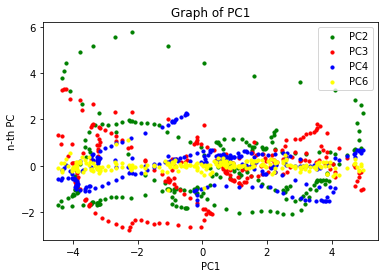

In [199]:
plt.xlabel('PC1')
plt.ylabel('n-th PC')
plt.title('Graph of PC1')
plt.scatter(pca_data[:,0], pca_data[:,1],  color='green', s=10, label='PC2')
plt.scatter(pca_data[:,0], pca_data[:,2],  color='red', s=10, label='PC3')
plt.scatter(pca_data[:,0], pca_data[:,3],  color='blue', s=10, label='PC4')
plt.scatter(pca_data[:,0], pca_data[:,5],  color='yellow', s=10, label='PC6')
plt.legend(loc="upper right")
plt.show()

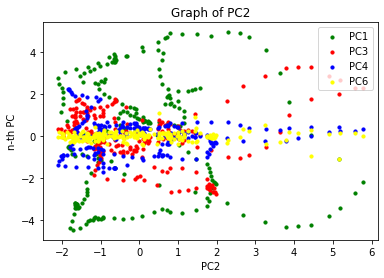

In [200]:
plt.xlabel('PC2')
plt.ylabel('n-th PC')
plt.title('Graph of PC2')
plt.scatter(pca_data[:,1], pca_data[:,0],  color='green', s=10, label='PC1')
plt.scatter(pca_data[:,1], pca_data[:,2],  color='red', s=10, label='PC3')
plt.scatter(pca_data[:,1], pca_data[:,3],  color='blue', s=10, label='PC4')
plt.scatter(pca_data[:,1], pca_data[:,5],  color='yellow', s=10, label='PC6')
plt.legend(loc="upper right")
plt.show()

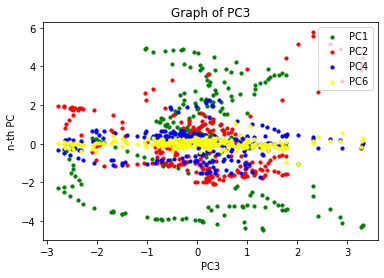

In [201]:
plt.xlabel('PC3')
plt.ylabel('n-th PC')
plt.title('Graph of PC3')
plt.scatter(pca_data[:,2], pca_data[:,0],  color='green', s=10, label='PC1')
plt.scatter(pca_data[:,2], pca_data[:,1],  color='red', s=10, label='PC2')
plt.scatter(pca_data[:,2], pca_data[:,3],  color='blue', s=10, label='PC4')
plt.scatter(pca_data[:,2], pca_data[:,5],  color='yellow', s=10, label='PC6')
plt.legend(loc="upper right")
plt.show()

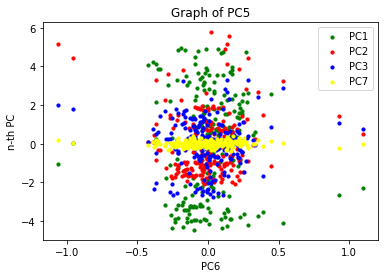

In [202]:
plt.xlabel('PC6')
plt.ylabel('n-th PC')
plt.title('Graph of PC5')
plt.scatter(pca_data[:,5], pca_data[:,0],  color='green', s=10, label='PC1')
plt.scatter(pca_data[:,5], pca_data[:,1],  color='red', s=10, label='PC2')
plt.scatter(pca_data[:,5], pca_data[:,2],  color='blue', s=10, label='PC3')
plt.scatter(pca_data[:,5], pca_data[:,6],  color='yellow', s=10, label='PC7')
plt.legend(loc="upper right")
plt.show()

In these 4 graphs it can be clearly seen that PC1 has the highest variance, while in the last graph, where the variance of PC5 is plotted against others, there isn't much of a different distribution. If we compare graph 1 with the last one, it can be seen how the values of other PCs range from such values as -4 to 4. However, for PC5, which now is known to only have 0.7% of all variance, it can also be seen that the value along the X axis are not distributed as much as in the first 3 graphs. 

<hr></hr>

# Question 3

For this question, the starting point as always is to have a custom Dataset for the faces images and the labels. Some variables for easier access are initialized and a custom Dataset class called "FacesDataset" is initialized as well. For the labels, the first column, which consists of the names for the images is discarded. After that, the training and testing datasets are initialized by using the custom Dataset class. It is tested by looking at lengths and tensor sizes of one entry.

Both the training and validation data is located in the folder data_q3q4 under its respective folder.

Since it is mentioned in the paper that the validation folder **validate** will be replaced with unseen data test, it is assumed that the folder will be in the same location and will be called the same, therefore no changes are required for the testing data set.

In [23]:
import os
import torch
import torch.nn as nn
import pandas
import numpy
import math
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Predefine some variables
training_data_folder = 'data_q3q4/train'
testing_data_folder = 'data_q3q4/validate'
labels_name = 'labels.csv'
to_tensor = transforms.ToTensor()

# Choose either the CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset for loading in the dataset of all faces and labels
class FacesDataset(Dataset):
    
    def __init__(self, directory_path, labels, transform=None):
        self.labels = pandas.read_csv(os.path.join(directory_path,labels), header=None)  # Read in the label CSV file
        self.directory_path = directory_path
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        path = os.path.join(self.directory_path, self.labels.iloc[index, 0])  # Get the path to each image
        image = Image.open(path)
        target_label = self.labels.iloc[:, 1:] # Target labels, ignore the first column
        target_label = torch.tensor(target_label.values) # Convert the csv to tensor
        target_label = target_label[index] # Get the label by index
        
        if self.transform:
            image = self.transform(image)
            
        return (image, target_label)
    
# Dataset variables
training_dataset = FacesDataset(training_data_folder, labels_name, to_tensor)
testing_dataset = FacesDataset(testing_data_folder, labels_name, to_tensor)

# Test the shapes and lengths of one entry
test_image_shape, test_label_shape = training_dataset[0]
print(f'Length of training dataset: {len(training_dataset)} ; and testing dataset: {len(testing_dataset)}')
print(f'Shape of image: {test_image_shape.shape}')
print(f'Shape of label: {test_label_shape.shape}')

Length of training dataset: 1838 ; and testing dataset: 256
Shape of image: torch.Size([1, 192, 160])
Shape of label: torch.Size([3])


The length of both training and testing datasets are correct. For the image the tensor has to be-   **Colour channels** x **Height** X **Width**. Since the height and width are 192 and 160 respectively, and the images are grayscale (1 colour channel), it can be seen that the tensors are of the correct size.

Now the DataLoaders can be initialized and batch size defined. The shape from the data loader can also be checked to make sure everything so far is correct.

In [24]:
batch_size = 50  # Make a batch size variable

training_data_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Test the data loader
images, labels = next(iter(training_data_loader))
print(f'Shape of the images: {images.shape}')  # BATCH SIZE  x  COLOUR CHANNELS  x  HEIGHT  x  WIDTH
print(f'Shape of the labels: {labels.shape}')  # BATCH SIZE  x  LIGHT DIRECTION

Shape of the images: torch.Size([50, 1, 192, 160])
Shape of the labels: torch.Size([50, 3])


Its time to choose how the model will be trained. Most of the time spent on this task was either fine tuning the number of epochs, learning rate and batch size or figuring out the best CNN architecture.

The main idea was to keep the final tensor to have the same width to height ratio, therefore before being flattened to fully connected layers, it ends up being of size **BATCH=50 x CHANNELS=22 x HEIGHT=23 x WIDTH=19**. The final tensor width and height size ended up being relatively big as any smaller than size 23x19 pixels usually ended up having a worse mean loss. In the network, some tests were done with both wider and deeper networks, however while wider network did not give any improvements, an extra layer(s) mostly affected the performance and also did not yeld any better results.

In the end, the philosophy of the network was to keep it narrow and not to complicate too much. Given, that the network has to find a light source direction, that would mean learning edges from the light source. As previsouly mentioned, this only kept proving that there was no need to complicate the network too much, as the goal here was not to extract small, complicated features.

In [25]:
class FaceLightSourceCNN(nn.Module):
    
    def __init__(self):
        
        super(FaceLightSourceCNN, self).__init__()
        
        # Convolution layers - foward the input through the convolution network
        self.convolution_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1),  # Tensor size [ BATCH  x  8  x  94  x  78 ]
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),  # Tensor size [ BATCH  x  16  x  47  x  39 ]
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=16, out_channels=22, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(22),
            nn.ReLU()  # Final tensor size [ BATCH  x  22  x  23  x  19 ]
        )

        # After the convolution layers the output needs to be flattened and layers fully connected
        self.flatten_connected_layer = nn.Sequential(
            nn.Linear(in_features=22*23*19, out_features=100),  # IN CHANNELS  x  WIDTH  x  HEIGHT
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=30),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(in_features=30,out_features=3)
        )

    def forward(self, x):
        x = self.convolution_layer(x)
        x = x.view(x.size(0), -1)  # Returns a new tensor so it can be flattened now
        x = self.flatten_connected_layer(x)
        
        # Output has dimensions BATCH x 3
        return x

cnn_training_model = FaceLightSourceCNN()

When initial training and testing was done, loss function used was Mean Squared Error (MSE). However, because of its nature, the MSE is not the best choise for training a regression model that has unit vectors as its main data type. Furthermore, since the angular error between the two vectors is what actually is looked for, the loss function will be a custom angular error loss function. 

The next code block defines the mean angular error loss function. It returns the loss in radians. The angular error (degrees) from radian can be seen after the model has been trained.

In [26]:
def mean_angular_error(predicted, labels):
    
    total_batch_loss = 0
    
    for i in range(len(predicted)):
        
        predicted_vector = torch.nn.functional.normalize(predicted[i], p=2, dim=0)  # Normalize the vector of predicted value
        labels_vector = labels[i]  # Already in normal form (length is 1 as described in the assessment paper)
        
        dot_product = torch.dot(labels_vector, predicted_vector)  # Calculate the dot product between normalized vectors
        loss = torch.acos(dot_product)  # Find the angle
        total_batch_loss += loss
        
    mean_angular_loss = total_batch_loss / len(predicted)  # The mean error for a batch
    
    return mean_angular_loss

Below, the training loop can be found. Epochs and learning rate had to be tuned in a trial-and-error way. This was done not only y looking at the mean loss, but also looking at plots of training loss and evaluation loss. This way if overfitting or underfitting was happening, it could clearly be seen visually (these graphs can be found after the training loop block). It was generally found, that any more than 17 epochs and the data would start to be overfitted. Less than that did not cause underfitting, however the mean loss did went up.

In [27]:
epochs = 17
learning_rate = 0.0005

cnn_training_model = cnn_training_model.to(device)
optimizer = torch.optim.Adam(cnn_training_model.parameters(), lr=learning_rate)

iterations_per_epoch = math.ceil(len(training_dataset)/batch_size)

# Save loss from every iteration in this variable
all_loses = []
evaluation_loses = []

for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(training_data_loader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        output = cnn_training_model(inputs)
        
        # Output tensor dtype is double by default, so convert it to float64
        output = output.to(dtype=torch.float64)
        
        loss = mean_angular_error(output,labels)
        
        all_loses.append(loss.detach().numpy())  # The loss value should be numpy friendly
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Some output to see how well the training is going
        if (i+1) % 15 == 0:
            print(f'Epoch: {epoch + 1}/{epochs};  Iteration: {i + 1}/{iterations_per_epoch};  Loss: {loss.item()}')
            
    # Evaluate the current model
    cnn_training_model.eval()
    with torch.no_grad():
        for inputs, labels in testing_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = cnn_training_model(inputs)
            output = output.to(dtype=torch.float64)
            loss = mean_angular_error(output,labels)
            evaluation_loses.append(loss.detach().numpy())
            
    cnn_training_model.train()  # Back to training
            
print('Training complete!')

Epoch: 1/17;  Iteration: 15/37;  Loss: 0.386140826284598
Epoch: 1/17;  Iteration: 30/37;  Loss: 0.31902165597956755
Epoch: 2/17;  Iteration: 15/37;  Loss: 0.18303440829580545
Epoch: 2/17;  Iteration: 30/37;  Loss: 0.14137750125285892
Epoch: 3/17;  Iteration: 15/37;  Loss: 0.12471036927748781
Epoch: 3/17;  Iteration: 30/37;  Loss: 0.1152435738323239
Epoch: 4/17;  Iteration: 15/37;  Loss: 0.17290205856041538
Epoch: 4/17;  Iteration: 30/37;  Loss: 0.19052671450369074
Epoch: 5/17;  Iteration: 15/37;  Loss: 0.12003459686758289
Epoch: 5/17;  Iteration: 30/37;  Loss: 0.16001559465116366
Epoch: 6/17;  Iteration: 15/37;  Loss: 0.1588151756750907
Epoch: 6/17;  Iteration: 30/37;  Loss: 0.11079027784184785
Epoch: 7/17;  Iteration: 15/37;  Loss: 0.1133505411878575
Epoch: 7/17;  Iteration: 30/37;  Loss: 0.0889620216967246
Epoch: 8/17;  Iteration: 15/37;  Loss: 0.11696591218355284
Epoch: 8/17;  Iteration: 30/37;  Loss: 0.10567336912899043
Epoch: 9/17;  Iteration: 15/37;  Loss: 0.13820940405827858
Epo

A closer look to the overall loss can now be seen.  In the graph below, the blue line plots all loss values from training, that way the progression can be seen. The red line is the mean value from all loss values.

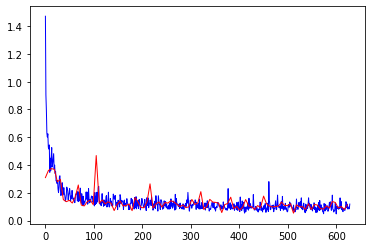

Mean training loss: 0.1334155265515193
Mean testing error: 0.13391726774313398


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

scaler = len(all_loses) / len(evaluation_loses)

# Plot loss values and the mean value
plt.plot([i for i in range(len(all_loses))], all_loses, color='blue', linewidth=1)
plt.plot([i*scaler for i in range(len(evaluation_loses))], evaluation_loses, color='red', linewidth=1)
plt.show()

mean_training_loss = numpy.mean(all_loses)
print(f'Mean training loss: {mean_training_loss}')

mean_testing_loss = numpy.mean(evaluation_loses)
print(f'Mean testing error: {mean_testing_loss}')

When observing the loss curve, it was noted that when the batch size was smaller, the fluctuation was highly increased and some overfitting could also be observed. However, in this case it can be seen that the red line is generally at the same line as the blue line, which is exactly what was looked for. If the red line was higher than the blue one, that would suggest an overfitting.

Moving on, the model can now be tested against the test dataset seperatly. The output of the code block below gives some output and label tensor values, which can be compared to see how close the model is predicting. Furthermore, the mean angular error can also be seen.

The output of the code block below is from the validation folder provided. Since it is mentioned in the paper that the validation folder will be replaced with unseen data test, it is assumed that the folder will be in the same location and will be called the same, therefore no changes are required.

In [29]:
errors = []

cnn_training_model.eval()

with torch.no_grad():
    for inputs, labels in testing_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = cnn_training_model(inputs)
        output = output.to(dtype=torch.float64)
        loss = mean_angular_error(output,labels)
        errors.append(loss.detach().numpy())
        
        print(f'Output: {torch.nn.functional.normalize(output[0], p=2, dim=0)}')  # Normalize the output tensor
        print(f'Label: {labels[0]} \n')
                                    
mean = numpy.mean(errors)
print(f'Mean error after the model has been trained: {mean}')
print(f'Mean angular error in degrees: {numpy.degrees(mean):.2f}°')

Output: tensor([ 0.6945,  0.2746, -0.6650], dtype=torch.float64)
Label: tensor([ 0.7198,  0.2620, -0.6428], dtype=torch.float64) 

Output: tensor([ 0.9054,  0.4238, -0.0249], dtype=torch.float64)
Label: tensor([0.9063, 0.4226, 0.0000], dtype=torch.float64) 

Output: tensor([ 0.4400, -0.8341, -0.3327], dtype=torch.float64)
Label: tensor([ 0.4698, -0.8138, -0.3420], dtype=torch.float64) 

Output: tensor([-0.5047,  0.6359,  0.5839], dtype=torch.float64)
Label: tensor([-0.5000,  0.8660,  0.0000], dtype=torch.float64) 

Output: tensor([ 0.4568, -0.8432, -0.2835], dtype=torch.float64)
Label: tensor([ 0.4698, -0.8138, -0.3420], dtype=torch.float64) 

Output: tensor([-0.1395, -0.9147, -0.3793], dtype=torch.float64)
Label: tensor([-0.3214, -0.8830, -0.3420], dtype=torch.float64) 

Mean error after the model has been trained: 0.10663546837235231
Mean angular error in degrees: 6.11°


As it can be seen, the provided test data gives mean angular error of just 6.11 degrees.

The code block below saves the weights to a file called q3_weights.pth

In [32]:
torch.save(cnn_training_model.state_dict(), 'q3_weights.pth')

Afterwards, the model can be tested by loading in the weights:

In [38]:
cnn_model = FaceLightSourceCNN()
cnn_model.load_state_dict(torch.load('q3_weights.pth'))

# Test can be continued

<All keys matched successfully>

<hr></hr>

# Question 4

Since GAN architecture is the building block for this question, the model below will follow the architecture of DCGAN with modifications for better results.

As before, start by introducing variables and choosing the device. In this case, the data folder designated can be the one containing both **train** and **validate** folders, since the in-built dataset class **ImageFolder** will automatically use both training and validation images.

The images are resized to 64 x 64. This gives 2 advantages other than training with full resolution images: <br>
    1) The network performance will be better since the resolution is smaller andd therefore also fewer layers will be required to upscale and downscale <br>
    2) Since the images now will have the same width and height, it is much easier to choose the kernel size which can be a single integer value instead of a tuple
    
The batch size was chosen 50 just as in Q3 as that felt to be the correct batch size. 100 would be too much for just 2000 samples and anything below 40-50 would also feel to little.

For the learning rate it seems that when learning rate is smaller, but number of epochs are large the generated faces will seem more detailed but a noise can be seen. However, for a bigger learning rate, the details seem to dissapear and the faces become more smooth overal. As in the DCGAN architecture, a learning rate of 0.0003 seems to be just right, as when it was increased the loss of details described before started to happen.

In [55]:
import os
import torch
import torch.nn as nn
import numpy
import math
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

# Define variables
data_folder = 'data_q3q4'  # Only the training data folder will be used, however labels are still used for length and path purposes
batch_size = 50
nz = 100 # generator input - Z latent vector
ngf = 64 # Generator feature maps
ndf = 64 # DDiscriminator feature maps
epochs = 20 # Number of training epochs
learning_rate = 0.0003
beta1 = 0.5 # Adam optimizer parameter
image_size = 64  # This time the images will be resized to 64x64 pixels as that seems to be the common image size for this kind of network

# Choose either the CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


As before, start with setting up the images. Since labels are no longer necessary, the previous defined dataset **FacesDataset** will not be neccessary and an inbuild dataset called **ImageFolder** can be used. This dataset class automatically assumes 3 colour channel, which is why the **transforms.Grayscale()** option is specified in the transformation.

In [56]:
# Create the dataset using ImageFolder class
all_faces_dataset = dset.ImageFolder(root=data_folder,
                           transform=transforms.Compose([
                               transforms.Grayscale(),  # Make sure there is only one channel
                               transforms.Resize(image_size),  # Reduce resolution
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(0.5,0.5)  # Normalize, as GAN will train better if the data is scaled between -1 and 1
                           ]))

faces_dataset = torch.utils.data.Subset(all_faces_dataset, numpy.random.choice(len(all_faces_dataset), 2000, replace=False))  # From all 2095 images choose 2000 random ones

# Create the dataloader
faces_data_loader = torch.utils.data.DataLoader(faces_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Now the dataset and dataloader can be tested by looking at its length (training images + validate images = 2095 images, however only 2000 images will be chosen as the batch size is set to 100), shape of one image (CHANNEL x HEIGHT x WIDTH  => 1 x 64 x 64) and shape of an entry in dataloader (BATCH x CHANNEL x HEIGHT x WIDTH  =>  100 x 1 x 64 x 64)

Length of training dataset: 2000
Shape of image: torch.Size([1, 64, 64])
Shape of the dataloader: torch.Size([50, 1, 64, 64])


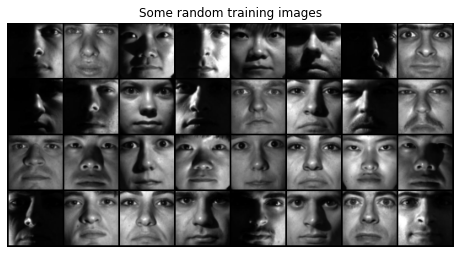

In [57]:
# Test the shapes and lengths of dataset and data loader
image_shape = faces_dataset
print(f'Length of training dataset: {len(faces_dataset)}')
print(f'Shape of image: {image_shape[0][0].shape}')

images = next(iter(faces_data_loader))
print(f'Shape of the dataloader: {images[0].shape}')  # BATCH SIZE  x  COLOUR CHANNELS  x  HEIGHT  x  WIDTH

# Plot some training images to make sure everything works
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Some random training images")
plt.imshow(numpy.transpose(vutils.make_grid(images[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

So far everything has been straight forward and similar to Q3 but with some modifications. After the neccessary variables and image dataset and dataloader have been set up, it's time to set up the generator CNN for upscaling and generating the faces.

In [58]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input Z of size BATCH x NZ x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # BATCH x (NGF*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # BATCH x (NGF*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # BATCH x (NGF*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # BATCH x 1 x 32 x 32
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # BATCH B x 1 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

generator_net = Generator()
generator_net = generator_net.to(device)

Now the discriminator can be setup for downscaling the images and choosing the label.

In [59]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input  1 x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # NGF x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (NGF*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (NGF*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (NGF*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
discriminator_net = Discriminator()
discriminator_net = discriminator_net.to(device)

The training loop can be found in the code block below. The losses are saved and later displayed for informational purposes.

In [60]:
# Initialize BCELoss function
loss_function = nn.BCELoss()

generator_losses = []
discriminator_losses = []

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
discriminator_optimizer = torch.optim.Adam(discriminator_net.parameters(), lr=learning_rate, betas=(beta1, 0.999))
generator_optimizer = torch.optim.Adam(generator_net.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Training Loop
for epoch in range(epochs):
    for index, (images,labels) in enumerate(faces_data_loader, 0):

        # Start by updating the discriminator network. As per DCGAN architecture, the aim 
        # here is to find max(log(D(x)) + log(1 - D(G(z))))
        
        # Start training with real images at first
        discriminator_net.zero_grad()
        real_images = images.to(device)
        output_label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Put the real images through the discriminator net
        output = discriminator_net(real_images).view(-1)
        # Loss on real image batch
        real_loss_discriminator = loss_function(output, output_label)
        # Calculate gradients for D in backward pass
        real_loss_discriminator.backward()
        discriminator_x = output.mean().item()

        # Now train with fakes
        # Get latent vectors
        latent_vectors = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate fake images with the generator net
        fake_image = generator_net(latent_vectors)
        output_label.fill_(fake_label)
        # Classify fake images
        output = discriminator_net(fake_image.detach()).view(-1)
        # Loss on fake images
        fake_loss_discriminator = loss_function(output, output_label)
        # Calculate the gradient for fake images
        fake_loss_discriminator.backward()
        output_gradient_1 = output.mean().item()
        # Get total loss from both real and fake batches
        total_discriminator_error = real_loss_discriminator + fake_loss_discriminator
        discriminator_optimizer.step()

        # Now the generator net finally can be updated and used.
        generator_net.zero_grad()
        # Fake labels classified as real
        output_label.fill_(real_label)
        # Put fake images through the discriminator net again since it was updated
        output = discriminator_net(fake_image).view(-1)
        # Generator's loss
        generator_error = loss_function(output, output_label)
        # Gradient for generator
        generator_error.backward()
        output_gradient_2 = output.mean().item()
        generator_optimizer.step()
        
        generator_losses.append(generator_error.item())
        discriminator_losses.append(total_discriminator_error.item())

        # Output to keep an eye out for improvements
        if index % 10 == 0:
            print(f'Epoch: {epoch + 1}/{epochs};  Iter: {index}/{len(faces_data_loader)}; D loss: {total_discriminator_error.item():.4f}; G loss: {generator_error.item():.4f}; '
                  f'D(x): {discriminator_x:.4f}; D(G(z)): {output_gradient_1:.4f}/{output_gradient_2:.4f}')

print('Training completed')

Epoch: 1/20;  Iter: 0/40; D loss: 1.4321; G loss: 3.4169; D(x): 0.4505; D(G(z)): 0.4574/0.0346
Epoch: 1/20;  Iter: 10/40; D loss: 0.0528; G loss: 7.7765; D(x): 0.9700; D(G(z)): 0.0211/0.0004
Epoch: 1/20;  Iter: 20/40; D loss: 0.0286; G loss: 9.3935; D(x): 0.9948; D(G(z)): 0.0231/0.0001
Epoch: 1/20;  Iter: 30/40; D loss: 0.0105; G loss: 8.2228; D(x): 0.9976; D(G(z)): 0.0081/0.0003
Epoch: 2/20;  Iter: 0/40; D loss: 0.0102; G loss: 7.9905; D(x): 0.9944; D(G(z)): 0.0045/0.0004
Epoch: 2/20;  Iter: 10/40; D loss: 0.0063; G loss: 7.7667; D(x): 0.9983; D(G(z)): 0.0045/0.0005
Epoch: 2/20;  Iter: 20/40; D loss: 0.0058; G loss: 8.4666; D(x): 0.9985; D(G(z)): 0.0043/0.0002
Epoch: 2/20;  Iter: 30/40; D loss: 0.0069; G loss: 8.0554; D(x): 0.9963; D(G(z)): 0.0032/0.0003
Epoch: 3/20;  Iter: 0/40; D loss: 0.0021; G loss: 8.4448; D(x): 0.9995; D(G(z)): 0.0016/0.0002
Epoch: 3/20;  Iter: 10/40; D loss: 0.0029; G loss: 8.2592; D(x): 0.9987; D(G(z)): 0.0016/0.0003
Epoch: 3/20;  Iter: 20/40; D loss: 0.0039; 

When the training has been completed, the generated images now can be sampled and a closer look to the losses can be taken.

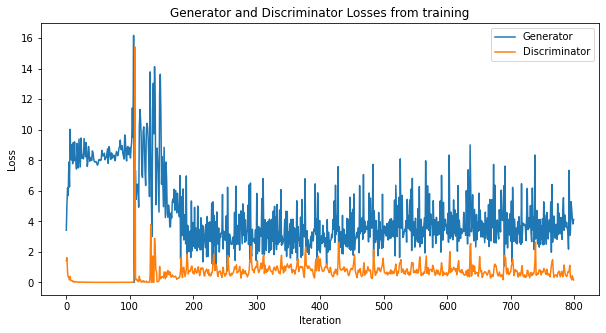

In [70]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses from training")
plt.plot(generator_losses,label="Generator")
plt.plot(discriminator_losses,label="Discriminator")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

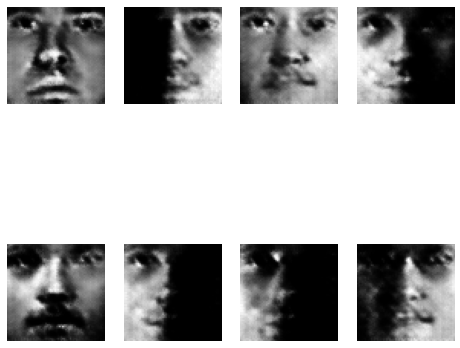

In [67]:
# Plot 8 images
images = generator_net(torch.randn(8, nz, 1, 1, device=device))
figure = plt.figure(figsize=(8, 8))
for i in range(4 * 2):
    figure.add_subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(images[i].cpu().detach().squeeze(), cmap="gray")
plt.show()

Just as in the provided images, it can be seen that the model has learned to also vary the lighting conditions. Now it is also possible to interpolate between two faces.

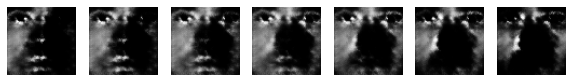

In [95]:
# Interpolate between 2 generated faces

num_of_images = 7  # Total images
image_vector_1 = torch.randn(1, nz, 1, 1, device=device)  # Image 1
image_vector_2 = torch.randn(1, nz, 1, 1, device=device)  # Image 2
generated_vector = torch.zeros(num_of_images,nz,1,1,device=device)  # Generated images in-between

# Generate the images by adding the vectors
for i in range(num_of_images):
  weight_1 = i/(num_of_images-1)
  weight_2 = 1-weight_1
  generated_vector[i,:,:,:] = weight_1*image_vector_1 + weight_2*image_vector_2
images = generator_net(generated_vector)

# Display interpolated images
figure = plt.figure(figsize=(10, 4))
for i in range(num_of_images):
    figure.add_subplot(1, num_of_images, i+1)
    plt.axis("off")
    plt.imshow(images[i,:].squeeze().cpu().detach(), cmap="gray")
plt.show()

The code tiles below saves and loads the weights of both networks.

In [96]:
torch.save(generator_net.state_dict(), 'q4_G_weights.pth')
torch.save(discriminator_net.state_dict(), 'q4_D_weights.pth')

In [97]:
loaded_gen_net = Generator()
loaded_dis_net = Discriminator()

loaded_gen_net.load_state_dict(torch.load('q4_G_weights.pth'))
loaded_dis_net.load_state_dict(torch.load('q4_D_weights.pth'))

<All keys matched successfully>